In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [49]:
class Atom:
    def __init__(self, symbol, x, y, z):
        self.symbol = symbol
        self.position = np.array([x, y, z])
    def __repr__(self):
        return f"Atom(symbol={self.symbol}, position={self.position})"

class Molecule(list):     ## We inherit from built-in class list
    def __init__(self, atoms):
        # Check that atoms is a sequence of atoms objects
        for a in atoms:
            assert isinstance(a, Atom)
        super().__init__(atoms)
    def get_positions(self):
        "Return the positions of all atoms as an Nx3 array"
        pos = []
        for a in self:      ## WAS:   for a in self.atoms:
            pos.append(a.position)
        return np.array(pos)
    def get_symbols(self):
        "Return a list of the chemical symbols of all atoms"
        symb = []
        for a in self:      ## WAS:   for a in self.atoms:
            symb.append(a.symbol)
        return symb
    def __repr__(self):
        "The representation - for brevity include only symbols"
        all_symbols = " ".join(self.get_symbols())
        return f"Atoms(N={len(self)}, symbols={all_symbols})"  ## WAS:  len(self.atoms)
    def write_to_file(self, filename):
        f = open(filename, "w")
        print(len(self), file=f)
        print("A molecule", file=f)
        template = "{}  {:.3f} {:.3f} {:.3f}"
        for a in self:      ## WAS:   for a in self.atoms:
            print(template.format(a.symbol, a.position[0], a.position[1], a.position[2]), file=f)
        f.close()
        
    # All magic methods are inherited from list

læser Lennard Jones parametrene for et givent grundstof fra txt filen:

In [50]:
def get_LJ_parameters(path, element):
    epsilon = None
    sigma = None
    with open(path, 'r') as f:
        for line in f:
            if line.startswith(element):
                parts = line.split()
                epsilon = float(parts[3])
                sigma = float(parts[4])
                break
    if epsilon is None or sigma is None:
        raise ValueError(f"Element {element} not found in file {path}")
    return epsilon, sigma

path_txt = 'LennardJones612_UniversalShifted.txt'
#Oxygen
chosen_element = 'O'
epsilon, sigma = get_LJ_parameters(path_txt, chosen_element)
print(f"{chosen_element}: epsilon={epsilon}, sigma={sigma}")


O: epsilon=5.12647, sigma=1.17599


In [ ]:
        
'''
       def system_energy(self, system):
        """Computes total potential energy of the system"""
        D = self.dist(system)  # NxN matrix
        np.fill_diagonal(D, np.inf)  # avoid division by zero
        E_matrix = self.U_pot(D)
        return 0.5 * np.sum(E_matrix)
'''

In [75]:
class LJ_energy_force:
    """Computes Lennard-Jones energy for molecules of the same atom type"""
    def __init__(self,epsilon, sigma):
        self.epsilon = epsilon
        self.sigma = sigma
        #self.element=element
        
    def calculate(self,system):
        E=self.calculate_energy(system)
        F=self.calculate_forces(system)
        return E,F
    
    def calculate_energy(self, system):
        """
        Looping over all pairs of atoms (not unique, but account for that by halving)
        and calculate energy per bond.
        """
        N=len(system)
        E=0
        D = self.dist(system)  # NxN distance matrix
        N = D.shape[0]
        for i in range(N):
            for j in range(N):  
                if i!=j:
                    r_ij = D[i,j]
                    U_ij = self.U_pot(r_ij)
                    E+=0.5*U_ij
            return E  #system energy
        
    def calculate_forces(self,system):
        N=len(system)
        F=np.zeros((N,3))
        D = self.dist(system)
        Upot_derived=0
        for k in range(N):
            for i in range(N):
                if i !=k:
                    Upot_derived=4*self.epsilon*(-12*(self.sigma**12/D[i,k]**13)+6*(self.sigma**6/D[i,k]**7))
                    F[k]+=Upot_derived*self.dist_derived(system,i,k)
        return F

    def dist_derived(self,system,i,k):
        D=self.dist(system)
        pos = system.get_positions()   #Nx3 array 
        r_k=pos[k]
        r_i=pos[i]
        dist_derived=(1/D[i,k])*(r_k-r_i)  
        return dist_derived
    
    def U_pot(self,r):
        """Lennard-Jones potential. r is the distances between 1 pair of atoms"""
        return 4 * self.epsilon * ((self.sigma / r)**12 - (self.sigma / r)**6)
    
    def dist(self, system, pair=None):
        """
        Computes distances between atoms.
            pair: None => return NxN distance matrix for the system(molecule) of N atoms
                 [i,j] => distance between atoms i and j
        """
        pos = system.get_positions()   #Nx3 array (maybe below I'm overcomplicating things with the broadcasting)
        if pair is None:
            diff = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]   #broadcasting trick
            self.dist_matrix=np.linalg.norm(diff, axis=2)
            return np.linalg.norm(diff, axis=2)  #norm bc. distance >0
        else:
            i, j = pair
            self.one_dist=np.linalg.norm(pos[i] - pos[j])
            return np.linalg.norm(pos[i] - pos[j])
        
    
    
    def plot_U_for_pair(self, d_min=0.1, d_max=None, n_points=1000):
        """Plot Lennard-Jones potential U(r)"""
        if d_max is None:
            d_max = 10 * self.sigma

        d_grid = np.linspace(d_min, d_max, n_points)
        U = self.U_pot(d_grid)

        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(d_grid, U)

        ax.set_xlabel('Distance')
        ax.set_ylabel('Lennard-Jones potential')
        ax.set_ylim(-10, 10)
        ax.set_title('LJ potential vs distance')
        ax.grid(True)


        plt.show()

    



In [85]:
#my energy class only works for one type of atom.
atoms = [
    Atom('O', 0, 0, 0),
    Atom('O', 0.96, 0, 0),
    #Atom('O', -0.32, 0.94, 0)
]

#O_2
molecule = Molecule(atoms)

lj = LJ_energy_force(epsilon, sigma)

In [88]:
lj_force=lj.calculate(molecule)[1]
print(lj_force)

[[ 2493.62831012     0.             0.        ]
 [-2493.62831012     0.             0.        ]]


Total LJ energy: 82.4225436787851


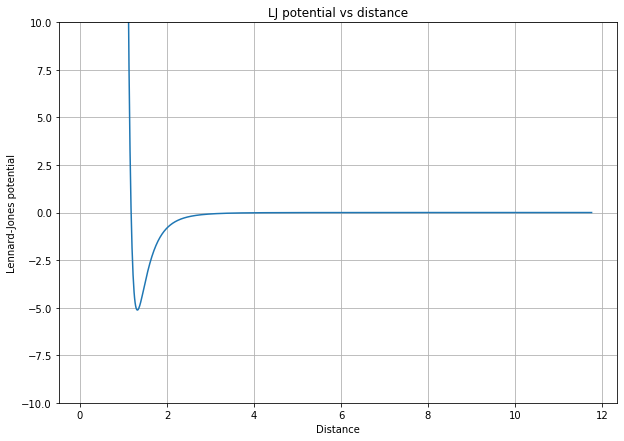

In [77]:
#my energy class only works for one type of atom.
atoms = [
    Atom('O', 0, 0, 0),
    Atom('O', 0.96, 0, 0),
    #Atom('O', -0.32, 0.94, 0)
]

#O_2
molecule = Molecule(atoms)


lj = LJ_energy_force(epsilon, sigma)

E_total = lj.calculate_energy(molecule)
print("Total LJ energy:", E_total)

lj.plot_U_for_pair()
